In [1]:
#this notebook is able to run both locally and in google colab
#if running in google colab, some additional actions need to be performed
#The variable IN_COLAB tells the code whether to perform those actions
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

#decide if running in GCP by hostname (if it contains -instance-20[0-9][0-9], then TRUE)
import re

IN_GCP = False

if not IN_COLAB:
    output = !hostname
    output_str = " ".join(output)

    if  bool(re.search(r'-instance-20\d{2}', output_str)): IN_GCP = True

print (f"IN_COLAB = {IN_COLAB}, IN_GCP = {IN_GCP} ")

IN_COLAB = True, IN_GCP = False 


# import all relevant libraries

In [2]:
#scraping
import requests
from requests import get
from bs4 import BeautifulSoup
from bs4 import NavigableString #not used
from urllib.request import urlopen #not used

#generally useful libraries
import numpy as np
import pandas as pd

#saving and loading reviews
import json
#saving and loading models
import joblib


#bag - of - words modelling
try:
    import nltk
except ImportError:
    !pip install nltk
!pip list | egrep "nltk"


from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import string



#sklearn
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder

#bart
try:
    import torch
except ImportError:
    !pip install torch torchvision torchaudio
!pip list | egrep "torch"

try:
    from transformers import BartTokenizer, BartForConditionalGeneration
except ImportError:
    !pip install transformers
!pip list | egrep "transformers"



from transformers import BartTokenizer, BartForConditionalGeneration

#navigate to folders
import os
import shutil


import time
# Define the number of CPU cores to use
from joblib import Parallel, delayed


##########



nltk                             3.8.1
torch                            2.2.1+cu121
torchaudio                       2.2.1+cu121
torchdata                        0.7.1
torchsummary                     1.5.1
torchtext                        0.17.1
torchvision                      0.17.1+cu121
transformers                     4.38.2


#mount drives and declare folder locations, create folders if necessary

In [3]:
if (IN_COLAB):  # the training data is loaded in the google drive for the purpose of being used in google colab
  from google.colab import drive
  drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#############################################################
#            subroutines to provide directory names
#############################################################
def where_am_I_running():
    if (IN_COLAB):
        return "Google colab"
    elif (IN_GCP):
        return "GCP"
    #return "jupyter on local computer"
    #return "python library on local computer"

def get_base_directory_name():
    if (where_am_I_running() == "python library on local computer"):
        folder_name = os.path.dirname(os.path.realpath(__file__))
        folder_name = folder_name.replace(\
                    "/summarize_reviews",     \
                    "/data/")
    elif (where_am_I_running() == "jupyter on local computer"):
        folder_name = os.getcwd() +  "/data/"
    elif (where_am_I_running() == "Google colab"):
        folder_name = "/content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/"
    elif (where_am_I_running() == "GCP"):
        folder_name = "/home/romanz/app/data/"

    folder_name = folder_name.replace("//", "/").replace("//", "/")
    return folder_name

def find_a_place_for_reviews_by_customers_clean():
    folder_name = get_base_directory_name() +  "/AllReviews_by_customers_clean/AllReviews_by_customers_clean.csv"
    folder_name = folder_name.replace("//", "/").replace("//", "/")
    return folder_name
def find_a_place_for_reviews_by_parkers ():
    folder_name = get_base_directory_name() +  "/reviews_from_parkers"
    folder_name = folder_name.replace("//", "/").replace("//", "/")
    return folder_name
def find_a_place_for_trained_classification_models ():
    folder_name = get_base_directory_name() +  "/trained_classification_models"
    folder_name = folder_name.replace("//", "/").replace("//", "/")
    return folder_name
def find_a_place_for_summaries ():
    folder_name = get_base_directory_name() +  "/summaries"
    folder_name = folder_name.replace("//", "/").replace("//", "/")
    return folder_name
def find_a_place_for_nltk_data_dir ():
    folder_name = get_base_directory_name() +  "/nltk_data_dir"
    folder_name = folder_name.replace("//", "/").replace("//", "/")
    return folder_name
def find_a_place_for_car_models_csv ():
    folder_name = get_base_directory_name() +  "/car_models_csv"
    folder_name = folder_name.replace("//", "/").replace("//", "/")
    return folder_name
def find_a_place_for_retreived_user_reviews_csv ():
    folder_name = get_base_directory_name() +  "/retreived_user_reviews/"
    folder_name = folder_name.replace("//", "/").replace("//", "/")
    return folder_name


In [5]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)



In [6]:
create_folder_if_not_exists(find_a_place_for_reviews_by_customers_clean())
create_folder_if_not_exists(find_a_place_for_reviews_by_parkers())
create_folder_if_not_exists(find_a_place_for_trained_classification_models())
create_folder_if_not_exists(find_a_place_for_summaries())
create_folder_if_not_exists(find_a_place_for_nltk_data_dir())
create_folder_if_not_exists(find_a_place_for_retreived_user_reviews_csv())



In [7]:
if (IN_COLAB):
  !cd /content/gdrive/MyDrive/'Colab Notebooks'/CarRecommendationEngine_classifySentences/data
elif (IN_GCP):
  !cd /home/romanz/app/data
!echo $PWD

/content


## service functions

In [8]:
def rm_multiple_spaces(text):
    # Split the text on spaces
    words = text.replace("\n", "NEWL").split()
    # Join the words back together with a single space between each word
    return ' '.join(words).replace("NEWL ","NEWL" ) .replace("NEWL","\n" )

# train classifier using bag of words model, NLTK library on Parkers data (labelled)

## read scraped reviews from Parkers

In [9]:
directory = find_a_place_for_reviews_by_parkers ()
directory

'/content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/reviews_from_parkers'

In [10]:
files = os.listdir(directory)
all_review_list = []
for current_file in files:
    with open(directory + "/" + current_file, 'r') as f:
        loaded_list = json.load(f)
        all_review_list.append(loaded_list)


print(all_review_list[-1])

[{'manufacturer': 'Corvette', 'model': 'C6', 'interior': 'The driver is presented with a simple dash on the Corvette and it’s all very easy to read and understand. An electrically adjusted drivers seat helps find the ideal driving position for most people, though some may find the steering wheel doesn’t have the range of movement necessary to get perfectly comfortable. The driver has good all-round vision in the Corvette thanks to the large glass rear hatch, through reversing can be tricky as it’s hard to judge where the rear of the car is from the driver’s seat. This is why most owners opt for rear parking sensors. Cabin quality is good, but some of the plastics look cheap next to the best Europe has to offer. The Corvette is a big car, so in theory there should be plenty of interior space. Unfortunately this isn’t the case and head, leg and shoulder room are all tighter than you may expect. The seats are generously padded, while the climate control is quick to cool or warm the cabin 

In [11]:
num_rows = len(all_review_list)
num_cols = len(all_review_list[0]) if all_review_list else 0
print(f"Shape of the list: {num_rows} rows x {num_cols} columns")

Shape of the list: 59 rows x 12 columns


In [12]:
def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list


In [13]:
all_review_list_flat = flatten(all_review_list)

In [14]:
num_rows = len(all_review_list_flat)
num_cols = len(all_review_list_flat[0]) if all_review_list_flat else 0
print(f"Shape of the list: {num_rows} rows x {num_cols} columns")

Shape of the list: 1012 rows x 6 columns


In [15]:
df_reviews = pd.DataFrame(all_review_list_flat)

In [16]:
# Remove rows containing 'n/a' entries
df_reviews = df_reviews[(df_reviews != 'n/a').all(axis=1)]

In [17]:
df_reviews.head()

,manufacturer,model,interior,practicality,engines,mpg_running_costs
0,TVR,Cerbera,Seats are snug and supportive. Like all TVRs t...,"No airbags, no traction control, no ABS brakes...",The 4.0-litre straight six offers 350bhp and a...,Residuals aren’t brilliant and you’ll have big...
5,TVR,T350,"TVRs trademark interior, which is good and bad...",Traction control is a matter of a long-travel ...,The 350 in the name relates to its engine outp...,Probably won’t lose too much off its value ini...
8,TVR,Tamora,"Being the base model, the Tamora doesn’t get s...",Little in the way of roll-over protection; no ...,"Impressively for a small company, TVR builds i...",All that firepower doesn’t come cheap – fuel a...
9,TVR,Tuscan,Just about the most spectacular looking car in...,"You don’t get airbags, ABS brakes, or traction...",The range kicks off with a 3.6-litre version o...,Specialist servicing doesn’t come cheap and it...
12,MINI,Clubman,If you’re familiar with MINIs then the Clubman...,"Pitched as the more practical MINI, the Clubma...",MINI trimmed the Clubman’s engine range with t...,Since the Cooper D disappeared from the price ...


In [18]:
#convert the dataframe into one column being review, and another column being classification of that review
df_only_reviews = df_reviews.drop(columns=["manufacturer", "model"]).reset_index(drop=True)
reviews_for_classification = df_only_reviews.melt(var_name='topic', value_name='review_text')
reviews_for_classification

,topic,review_text
0,interior,Seats are snug and supportive. Like all TVRs t...
1,interior,"TVRs trademark interior, which is good and bad..."
2,interior,"Being the base model, the Tamora doesn’t get s..."
3,interior,Just about the most spectacular looking car in...
4,interior,If you’re familiar with MINIs then the Clubman...
...,...,...
2303,mpg_running_costs,Lexus says the RX 450h+ can manage more than 2...
2304,mpg_running_costs,Running costs vary wildly depending on where y...
2305,mpg_running_costs,With a thirsty V8 engine capable of just 25mpg...
2306,mpg_running_costs,"With just one engine available, it’s easy to s..."


## LabelEncode target and store it into a column called `"topic_encoded"`


In [19]:
# YOUR CODE HERE
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(reviews_for_classification["topic"])
le.classes_
reviews_for_classification["topic_encoded"] = le.transform (reviews_for_classification["topic"])

<Axes: title={'center': 'Scatter Plot'}, xlabel='topic', ylabel='topic_encoded'>

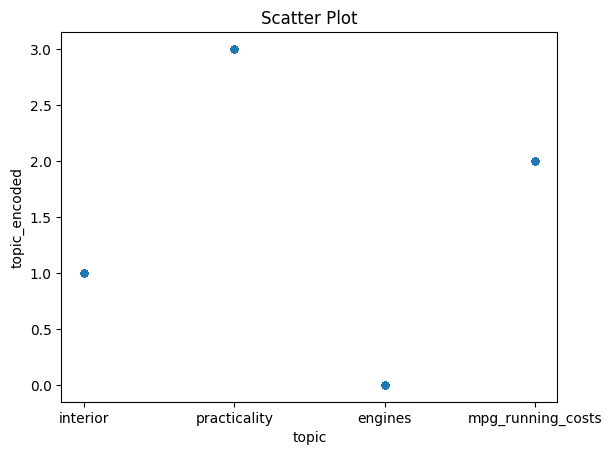

In [20]:
reviews_for_classification.plot(x='topic', y='topic_encoded', kind='scatter', title='Scatter Plot')


In [21]:
#create dictionary for reverse transformation


# Apply filter to DataFrame - only keep zeroth row of each topic, keep only columns "topic" and "topic_encoded"
result = reviews_for_classification.groupby('topic').first().reset_index().loc[:, ["topic","topic_encoded"]]

# Make column 'topic_encoded' as the index
result.set_index('topic_encoded', inplace=True)

# convert df to dictionary

decode_topic_dict = result.to_dict()['topic']
decode_topic_dict

{0: 'engines', 1: 'interior', 2: 'mpg_running_costs', 3: 'practicality'}

## subroutines to preprocess text

In [22]:

#create a class that handles the downloading of NLTK data and setting
# On first instantiation, download NLTK data
# On subsequent instantiations, the class will skip the download process.

class NLTKWordDownloader:
    _downloaded = False

    @classmethod
    def download_wordnet(cls):
        if not cls._downloaded:
            nltk.download('stopwords')
            nltk.download('punkt')
            nltk.download('wordnet')
            nltk.download('omw-1.4')

            cls._downloaded = True



In [23]:
def remove_punctuation(text, debug=0):
    if (debug): print (f"remove_punctuation text  ={text}")
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    return text
def lowercase (text, debug=0):
    if (debug): print (f"lowercase text  ={text}")

    lowercased = text.lower()
    return lowercased
def remove_numbers (text, debug=0):
    if (debug): print (f"remove_numbers text  ={text}")

    words_only = ''.join([i for i in text if not i.isdigit()])
    return words_only

def remove_stopwords (text, debug=0):
    if (debug): print (f"remove_stopwords text  ={text}")

    download_new_nltk_every_time = 0

    if (download_new_nltk_every_time):
        nltk.download('stopwords')
        nltk.download('punkt')
        nltk.download('wordnet')
        nltk.download('omw-1.4')
    else:
        NLTKWordDownloader.download_wordnet()

    # From now on, NLTK data will be available
    # and NLTK_DATA environment variable will be set

    stop_words = set(stopwords.words('english'))

    tokenized = word_tokenize(text)
    without_stopwords = [word for word in tokenized if not word in stop_words]
    return without_stopwords
def lemma(text, debug=0):
    if (debug): print (f"lemma text  ={text}")

    lemmatizer = WordNetLemmatizer() # Instantiate lemmatizer
    lemmatized = [lemmatizer.lemmatize(word) for word in text] # Lemmatize
    lemmatized_string = " ".join(lemmatized)
    return lemmatized_string

def all_preprocessing(text, debug=0):
    debug=0
    preprocessed_texts = []
    for current_line in text: # the subtourine accepts a numpy array of sentences and returns a list. This allows it to be used in the pipeline
        output = remove_punctuation(current_line, debug)
        output = lowercase(output)
        output = remove_numbers(output, debug)
        output = remove_stopwords(output, debug)
        output = lemma(output, debug)
        preprocessed_texts.append(output)
    return preprocessed_texts



##      custom classifier based on logistic regression but with variable threshold


In [24]:



class CustomClassifier():
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.model = LogisticRegression()

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        probabilities = self.model.predict_proba(X)
        max_probabilities = np.max(probabilities, axis=1)
        predictions = np.argmax(probabilities, axis=1)
        predictions[max_probabilities < self.threshold] = -1  # Assign a separate class label for cases below threshold
        return predictions

    def transform(self, X):
        return X  # This is a dummy method as FeatureUnion requires all estimators to implement 'transform'



##     subroutines to train classifier models on Parkers data

In [25]:



def train_data_classification_models_on_parkers_data(debug):
    #############################################################
    #            preprocess labelled text
    #############################################################

    # Directory path
    directory = find_a_place_for_reviews_by_parkers()
    if (debug):
        print (f"directory = {directory}")

    # Get a list of files in the directory
    files = os.listdir(directory)

    all_review_list = []
    for current_file in files:
        with open(directory + "/" + current_file, 'r') as f:
            loaded_list = json.load(f)
            all_review_list.append(loaded_list)

    if (debug):
        print(f"all_review_list[-1] = {all_review_list[-1]}\n=================")



    all_review_list_flat = flatten(all_review_list)
    df_reviews = pd.DataFrame(all_review_list_flat)

    # Remove rows containing 'n/a' entries
    df_reviews = df_reviews[(df_reviews != 'n/a').all(axis=1)]

    #convert the dataframe into one column being review, and another column being classification of that review
    df_only_reviews = df_reviews.drop(columns=["manufacturer", "model"]).reset_index(drop=True)

    reviews_for_classification = df_only_reviews.melt(var_name='topic', value_name='review_text')

    if (debug):
        print(f"reviews_for_classification = \n{reviews_for_classification}\n=================")

    #############################################################
    #            encode labels
    #############################################################

    #encode labels
    le = LabelEncoder()
    le.fit(reviews_for_classification["topic"])
    reviews_for_classification["topic_encoded"] = le.transform (reviews_for_classification["topic"])

    #create dictionary for reverse transformation


    # Apply filter to DataFrame - only keep zeroth row of each topic, keep only columns "topic" and "topic_encoded"
    result = reviews_for_classification.groupby('topic').first().reset_index().loc[:, ["topic","topic_encoded"]]

    # Make column 'topic_encoded' as the index
    result.set_index('topic_encoded', inplace=True)

    # convert df to dictionary

    decode_topic_dict = result.to_dict()['topic']
    if (debug):
        print(f"decode_topic_dict = \n{decode_topic_dict}\n=================")

    # Save dictionary to a JSON file
    dict_file = find_a_place_for_trained_classification_models() + "/" +  "decode_topic_dict.json"

    if (debug):
        print(f"dict_file = \n{dict_file}\n=================")

    with open(dict_file , 'w') as f:
        json.dump(decode_topic_dict, f)

In [26]:
train_data_classification_models_on_parkers_data(debug = 1)

directory = /content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/reviews_from_parkers
all_review_list[-1] = [{'manufacturer': 'Corvette', 'model': 'C6', 'interior': 'The driver is presented with a simple dash on the Corvette and it’s all very easy to read and understand. An electrically adjusted drivers seat helps find the ideal driving position for most people, though some may find the steering wheel doesn’t have the range of movement necessary to get perfectly comfortable. The driver has good all-round vision in the Corvette thanks to the large glass rear hatch, through reversing can be tricky as it’s hard to judge where the rear of the car is from the driver’s seat. This is why most owners opt for rear parking sensors. Cabin quality is good, but some of the plastics look cheap next to the best Europe has to offer. The Corvette is a big car, so in theory there should be plenty of interior space. Unfortunately this isn’t the case and head, leg and sho

##            define & train pipelines


In [27]:
# Create multiple instances of CustomClassifier with different thresholds
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
classifiers = [CustomClassifier(threshold=threshold) for threshold in thresholds]


# Create pipelines for each classifier


pipelines = [Pipeline([
    ('preprocessor', FunctionTransformer(all_preprocessing)),  # Custom preprocessing step
    ('vectorizer', CountVectorizer()),
    ('classifier', classifier)
]) for classifier in classifiers]

X_train, X_test, y_train, y_test = train_test_split( reviews_for_classification["review_text"].values,
                                                    reviews_for_classification["topic_encoded"].values,
                                                    test_size=0.05,
                                                    random_state=42)
print (f"X_train = {X_train}")
# Train pipelines with differing thresholds
for pipeline in pipelines:
    pipeline.fit(X_train, y_train)

# Save the trained pipelines to a file
debug = 1
for pipeline_no, pipeline in enumerate(pipelines):
    fname = find_a_place_for_trained_classification_models() + "/" + f'trained_pipeline_{pipeline_no}.pkl'
    if (debug):
        print (f"fname = {fname}")
    joblib.dump(pipeline, fname)




X_train = ['‘Sensible’ is probably the best way to describe the Kia Ceed’s interior. That’s both good and bad – it does mean there are fewer aspects likely to annoy you as a driver, like the Volkswagen Golf’s unresponsive touchscreens, but there’s not much to surprise or delight either. It’s certainly easy to get along with. The Ceed’s switchgear is all positioned logically, and the standard-fit touchscreen infotainment system has a simple and intuitive interface. It’s just a shame that it’s all so unrelentingly dark – the plastics used aren’t particularly nice to touch, even if they do feel very well put-together. Entry-level Ceeds come with an 8-inch touchscreen infotainment system plus a small screen between the dials of the instrument panel. Higher-spec models upgrade both screens, with a larger one in the instrument panel and a 10.25-inch infotainment screen. Fundamentally, though, this is a cosmetic upgrade, and they all work in the same way. Apple CarPlay and Android Auto are st

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


fname = /content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_0.pkl
fname = /content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_1.pkl
fname = /content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_2.pkl
fname = /content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_3.pkl
fname = /content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_4.pkl
fname = /content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_5.pkl
fname = /content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classific

#      split text in sentences, categorize them and summarize them


## subrotine to split text in sentences and categorize it based on pre - trained pipelines

In [28]:
class CachedClassificationModels:
    _cached_pipelines = {}  # Class-level variable to hold the cached DataFrame
    _cached_dict = {}

    def __init__(self):
        pass

    def retreive_classification_pipelines (self):
        debug = 0
        if not CachedClassificationModels._cached_pipelines :
            # Read pipelines from HDD on first instantiation
            CachedClassificationModels._cached_pipelines = self._get_all_pipelines()
            if (debug):
                print("DataFrame read from file")
        else:
            if (debug):
                print("Using cached DataFrame")

        return CachedClassificationModels._cached_pipelines


    #############################################################
    #            loading up all classification pielines from HDD
    #############################################################

    def _get_all_pipelines (debug=0):

        #load up all customer reviews for all models
        #load up pipelines from HDD
        pipelines = {}
        for pipeline_no in range (0,13):
            fname = find_a_place_for_trained_classification_models() + "/" + f'trained_pipeline_{pipeline_no}.pkl'
            if (debug):
                print (f"loading pretrained classification model from file = \n{fname}")
            pipelines[pipeline_no] = joblib.load(fname)

        return pipelines



    def retreive_decode_dictionary (self):
        debug = 1
        if not CachedClassificationModels._cached_dict :
            # Read pipelines from HDD on first instantiation
            CachedClassificationModels._cached_dict = self._get_decode_dictionary()
            if (debug):
                print("DataFrame read from file")
        else:
            if (debug):
                print("Using cached DataFrame")

        return CachedClassificationModels._cached_dict


    #############################################################
    #            loading up decode dictionary from HDD
    #############################################################

    def _get_decode_dictionary (debug=0):

        #load up all customer reviews for all models
        #load up pipelines from HDD

        dict_file = find_a_place_for_trained_classification_models() + "/" +  "decode_topic_dict.json"
        with open(dict_file, 'r') as f:
            decode_topic_dict = json.load(f)
        #print (f"decode_topic_dict = {decode_topic_dict}")
        return decode_topic_dict





In [29]:
# Function to count words in a text
def count_words(text):
    return len(str(text).split())

# Function to count rows where number of words exceeds 100
def count_rows_exceeding_threshold(column):
    return sum(column.apply(count_words) > 100)


In [30]:
def categorize_text2(user_reviews, TargetTextSize = 1000,  debug=0):

  #this is an alternative approach to categorize text:
  #(1) split text in categories with model #0 (with lowest precision);
  #(2) for text in each category, progressively increase precision until TargetTextSize is reached

#############################################################
#     text pre - processing
#############################################################


    sentences = sent_tokenize(user_reviews)

    # Convert list of sentences into a NumPy array
    sentences_df = pd.DataFrame(sentences)
    sentences_df.columns = ['sentence']

    if (debug):
        print (rm_multiple_spaces(\
            f"\n=================\n \
            sentences_df on the input = \n\
            {sentences_df }\n\
            =================\n"))

    #load up pipelines from HDD
    cached_class_pipelines_instance = CachedClassificationModels()
    pipelines = cached_class_pipelines_instance.retreive_classification_pipelines()
    #pipelines


#############################################################
#     rough sentence categorization with pipeline #0
#############################################################

    #categorize sentences - apply pipeline to sentence and generate another column
    #as there are several pipelines, there are several different categorizations

    pipeline = pipelines[0]
    sentences_df['topic_pipeline0'] = pipeline.predict(sentences_df['sentence'])

    #make sure that each class is present in at least one row of the dataframe, as otherwise summary won't work

    def add_row_to_df(df, values_in_row):
        new_row = pd.Series([values_in_row] * len(df.columns), index=df.columns)
        new_row["sentence"] =" "
        df = df.append(new_row, ignore_index=True)
        #df = pd.concat([df, new_row], ignore_index=True)
        return df

    sentences_df = add_row_to_df(sentences_df, 0)
    sentences_df = add_row_to_df(sentences_df, 1)
    sentences_df = add_row_to_df(sentences_df, 2)
    sentences_df = add_row_to_df(sentences_df, 3)


    if (debug):
        print (rm_multiple_spaces(\
            f"\n=================\n \
            sentences_df  = \n\
            {sentences_df }\n\
            =================\n"))

    early_stop  =0
    if (early_stop):
        return
#############################################################
# concatenate all sentences belonging to each topic
#############################################################

    concatenated_text_rough = \
                sentences_df.groupby('topic_pipeline0')['sentence'].apply(lambda x: ' '.join(x))#.reset_index()['sentence']

    concatenated_text_rough_df = pd.DataFrame(concatenated_text_rough)
    concatenated_text_rough_df = concatenated_text_rough_df.rename_axis('topic')
    concatenated_text_rough_df['word_count'] = concatenated_text_rough_df['sentence'].apply(lambda x: count_words(x))

    if (debug):
        print (rm_multiple_spaces(\
            f"\n=================\n \
            concatenated_text_rough_df  = \n\
            {concatenated_text_rough_df }\n\
            =================\n"))

    early_stop  =0
    if (early_stop):
        return

#############################################################
# go through each topic of concatenated_text_rough.
# If number of words is greater than target, apply
# progressively stricter classification models until
# target number of words is reached
#############################################################
    # Define a filter function
    def filter_function(text1, topic, TargetTextSize):
        # count number of words in the sentence - if it's below TargetTextSize, return sentence unmodified
        if ( count_words(text1) <= TargetTextSize):
            return text1
        else: #
          # split text in sentences
          sentences1 = sent_tokenize(text1)
          sentences1_df = pd.DataFrame(sentences1)
          sentences1_df.columns = ['sentence']

          for pipeline_no in range (1, 13):
            pipeline = pipelines[pipeline_no]
            sentences1_df['topic1'] = pipeline.predict(sentences1_df['sentence'])

            # concatenate all sentences belonging to each topic
            concatenated_text1 = \
                sentences1_df.groupby(f'topic1')['sentence'].apply(lambda x: ' '.join(x)) #.reset_index()['sentence']

            concatenated_text1_df = pd.DataFrame(concatenated_text1)
            concatenated_text1_df = concatenated_text1_df.rename_axis('topic')
            concatenated_text1_df['word_count'] = concatenated_text1_df['sentence'].apply(lambda x: count_words(x))

            concat_text = concatenated_text1_df.loc[int(topic), 'sentence']
            word_count = concatenated_text1_df.loc[int(topic), 'word_count']

            #print (f"filter_function concatenated_text1_df = {concatenated_text1_df}")
            #print (f"word count = {concatenated_text1_df.loc[int(topic), 'word_count']}")
            #print (f"concat_text = {concat_text}")

          return concat_text


    # Cycle through topics, applying filter_function to the set of filtered topics
    for topic in concatenated_text_rough_df.index:

        retrieved_string = concatenated_text_rough_df.loc[int(topic), 'sentence']
        concatenated_text_rough_df.loc[int(topic), 'filtered_sentence'] =\
            filter_function(retrieved_string, topic, TargetTextSize)


    concatenated_text_rough_df['word_count_filtered'] = concatenated_text_rough_df['filtered_sentence'].apply(lambda x: count_words(x))

    if (debug):
        print (rm_multiple_spaces(\
            f"\n=================\n \
            concatenated_text_rough_df  = \n\
            {concatenated_text_rough_df }\n\
            =================\n"))

    # clean up the dataframe
    concatenated_text_rough_df.rename(columns={'filtered_sentence': 'review_selected_text'}, inplace=True)
    concatenated_text_rough_df = concatenated_text_rough_df.drop(columns=["sentence", "word_count", ])
    concatenated_text_rough_df['topic'] = concatenated_text_rough_df.index

    concatenated_text = concatenated_text_rough_df



#############################################################
#     Reverse label encoder
#############################################################

    # Reverse label encoder using dictionary
    #read the dictionary

    # load dictionary from a JSON file

    #dict_file = find_a_place_for_trained_classification_models() + "/" +  "decode_topic_dict.json"

    #with open(dict_file, 'r') as f:
    #    #decode_topic_dict = json.load(f, object_hook=parse_int_keys)
    #    decode_topic_dict = json.load(f)

    decode_topic_dict = cached_class_pipelines_instance.retreive_decode_dictionary()


    if (debug):
        print (f"decode_topic_dict = \n{decode_topic_dict}")

    #debug
    #decode_topic_dict = {"0": 'engines', "1": 'interior', "2": 'mpg_running_costs', "3": 'practicality'}
    # Convert column 'topic' from integer to string
    concatenated_text['topic'] = concatenated_text['topic'].astype(str)

    concatenated_text['topic_decoded'] = concatenated_text.topic.map(decode_topic_dict)

    if (debug):
        print (rm_multiple_spaces(\
            f"\n=================\n \
            categorized concatenated_text with decoded label = \n\
            {concatenated_text }\n\
            =================\n"))


    return concatenated_text

In [31]:
#create a class that handles reading customer reviews from HDD
# On first instantiation, reading customer reviews from HDD
# On subsequent instantiations, the class will skip the read from HDD
# and return cached dataframe from RAM
def lowercase(text):
    return text.lower()  # Define or import the lowercase function

class CachedCustomerReviews:
    _cached_df = None  # Class-level variable to hold the cached DataFrame

    def __init__(self):
        pass


    def retreive_customer_reviews (self):
        if CachedCustomerReviews._cached_df is None:
            # Read DataFrame from file on first instantiation
            CachedCustomerReviews._cached_df = self._get_all_customer_reviews()
            print("DataFrame read from file")
        else:
            print("Using cached DataFrame")
        return CachedCustomerReviews._cached_df


    #############################################################
    #            loading up all customer reviews from HDD
    #############################################################

    def _get_all_customer_reviews (debug=0):

        #load up all customer reviews for all models
        AllReviews_by_customers_clean_fname  =  find_a_place_for_reviews_by_customers_clean()

        df_all_car_reviews_by_customers = pd.read_csv(AllReviews_by_customers_clean_fname)
        df_all_car_reviews_by_customers.columns = ['key', 'manufacturer', 'old_key', 'review_date','reviewer_name', 'model', 'review_title','review_body', 'stars']
        df_all_car_reviews_by_customers.drop(columns=['key', 'old_key', 'reviewer_name'], inplace=True)
        df_all_car_reviews_by_customers['manufacturer'] = df_all_car_reviews_by_customers.manufacturer.apply(lowercase)
        df_all_car_reviews_by_customers['model'] = df_all_car_reviews_by_customers.model.apply(lowercase)

        #if (debug):
        #    print (f"df_all_car_reviews_by_customers = \n{df_all_car_reviews_by_customers}\n===============")

        return df_all_car_reviews_by_customers



In [32]:
cached_customer_reviews_instance = CachedCustomerReviews()
customer_reviews = cached_customer_reviews_instance.retreive_customer_reviews()
customer_reviews

DataFrame read from file


,manufacturer,review_date,model,review_title,review_body,stars
0,acura,on 07/03/17 09:06 AM (PDT),2014 acura rlx sedan technology package 4dr se...,RLXer,Fast lots of room good gas mileage if you kee...,4.000
1,acura,on 01/02/17 17:02 PM (PST),2014 acura rlx sedan advance package 4dr sedan...,Wish I had a better RLX story,"2014 Acura RLX, with advanced package, purcha...",1.000
2,acura,on 02/22/16 14:48 PM (PST),2014 acura rlx sedan 4dr sedan (3.5l 6cyl 6a),Almost Perfect,"There is a lot to like about this car, and fr...",4.000
3,acura,on 11/02/15 18:50 PM (PST),2014 acura rlx sedan navigation 4dr sedan (3.5...,"Overall, great car but it does have some problems","I'm very happy with the performance, handling...",3.000
4,acura,on 10/23/15 23:45 PM (PDT),2014 acura rlx sedan navigation 4dr sedan (3.5...,"Drives Great ""IF"" You Can Get it to Start!",Purchased my 2014 RLX in May 2014. Other tha...,4.000
...,...,...,...,...,...,...
236507,volvo,on 05/02/09 20:12 PM (PDT),2009 volvo c30 hatchback t5 r-design 2dr hatch...,Love this car!,"Not the fastest thing out there, but no slouc...",4.750
236508,volvo,on 02/10/09 12:03 PM (PST),2009 volvo c30 hatchback t5 r-design 2dr hatch...,This is what I was looking for,"I've only had this car a few weeks, but was l...",4.750
236509,volvo,on 01/14/09 04:53 AM (PST),2009 volvo c30 hatchback t5 r-design 2dr hatch...,Fun Car,Caveat this review with the fact I've only ow...,4.875
236510,volvo,on 01/02/09 20:20 PM (PST),2009 volvo c30 hatchback t5 r-design 2dr hatch...,my first Volvo,"I now have 860 miles on my new C30, and I am ...",4.000


In [33]:
BBB = cached_customer_reviews_instance.retreive_customer_reviews()
CCC = ""
for i in range(0,40):
  CCC = CCC + BBB.loc[i, "review_body"]
CCC

Using cached DataFrame


' Fast lots of room good gas mileage if you keep your foot off the accelerator 2014 Acura RLX, with advanced package, purchased 3/14 at Pleasanton Acura•\tOn going electrical, entertainment system, fit and finish, suspension, electronics, backup camera, accessory issues:•\t13 visits to dealer on car issues•\t18 days the car was at the dealers for repairs•\t4 immediate returns to the dealer due to repairs incorrect or not complete•\t4 sessions working with dealer service personnel to show them how to debug issues; DTS audio, USB file interface, battery cell failure, internal recirculating fan•\t2 wheels bent due to road damage•\t0 time I have had wheel damage due to road damage on other vehicles•\t1 factory wheel cost covered cost for 4 new wheels and tires in aftermarket•\t>40 hours, amount of time spent dealing with car problems•\t1 safety issue, video recorded, which Acura says they will not fix•\t4 videos recorded to show problems to service personnel because their first response is

In [34]:
concatenated_text = categorize_text2(CCC, TargetTextSize = 1000,  debug=0)

loading pretrained classification model from file = 
/content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_0.pkl
loading pretrained classification model from file = 
/content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_1.pkl
loading pretrained classification model from file = 
/content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_2.pkl
loading pretrained classification model from file = 
/content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_3.pkl
loading pretrained classification model from file = 
/content/gdrive/MyDrive/Colab Notebooks/CarRecommendationEngine_classifySentences/data/trained_classification_models/trained_pipeline_4.pkl
loading pretrained classification m

<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


DataFrame read from file


In [35]:
concatenated_text

,review_selected_text,word_count_filtered,topic,topic_decoded
topic,,,,
0,"The ride is plenty smooth, the transmission fe...",166,0,engines
1,Lots of room in the back seat. This car is a l...,133,1,interior
2,Fast lots of room good gas mileage if you kee...,1082,2,mpg_running_costs
3,,0,3,practicality


In [36]:
concatenated_text.loc[0, "review_selected_text"]

'The ride is plenty smooth, the transmission feels great shifting in all gears, A/C is perfect. Acura plays by no one elses rules as far as I can tell.Every competitors car that Acura claims the Acura RLX competes with is either rear wheel drive or all wheel drive.The RLX is front wheel drive with Rear Wheel Precision Steer.Initial marketing reasons would conclude its silly for Acura to say they compete with those other cars, but the truth is when you drive the RLX and feel how wonderfully precise it is and how nice the drive is you have to ask yourself why would I want all wheel drive with more things to break and horrible fuel economy.I have had my RLX now for 1000+ miles and I love it.The more I drive it the more I love it.I have owned Lexus LS430, ES300h, BMW... Quick on the acceleration and grabs corners like a magnet, rides smooth even over very deep pot holes and high speed bumps.  '

In [37]:
concatenated_text.loc[1, "review_selected_text"]

"Lots of room in the back seat. This car is a lot quieter, rides better/smoother, has better visibility, and interior materials. Not to mention--- the roomy, rear seat, , the quiet cabin, the improved suspension, the way it climbs a hill and never downshifts, not to mention its' classic, elegant appearance. Its comfortable for long and short rides, quite sporty and, when driven a bit aggressively/sport mode, will certainly demand the driver's attention to keep the shiny side up. I've owned Hondas exclusively since I turned 16 and each one, even my old '83 Accord SE, had a lever to pop the trunk from the driver's seat. Overall, I prefer the interior of my previous '98 Accord EX coupe for features but the leather seats offer great support and comfort in the turns.  "

In [38]:
concatenated_text.loc[2, "review_selected_text"]

' Fast lots of room good gas mileage if you keep your foot off the accelerator 2014 Acura RLX, with advanced package, purchased 3/14 at Pleasanton Acura•\tOn going electrical, entertainment system, fit and finish, suspension, electronics, backup camera, accessory issues:•\t13 visits to dealer on car issues•\t18 days the car was at the dealers for repairs•\t4 immediate returns to the dealer due to repairs incorrect or not complete•\t4 sessions working with dealer service personnel to show them how to debug issues; DTS audio, USB file interface, battery cell failure, internal recirculating fan•\t2 wheels bent due to road damage•\t0 time I have had wheel damage due to road damage on other vehicles•\t1 factory wheel cost covered cost for 4 new wheels and tires in aftermarket•\t>40 hours, amount of time spent dealing with car problems•\t1 safety issue, video recorded, which Acura says they will not fix•\t4 videos recorded to show problems to service personnel because their first response is

In [39]:
def count_words(text):
    return len(text.split())

concatenated_text['word_count'] = concatenated_text['review_selected_text'].apply(lambda x: count_words(x))
print(concatenated_text)

                                    review_selected_text  word_count_filtered  \
topic                                                                           
0      The ride is plenty smooth, the transmission fe...                  166   
1      Lots of room in the back seat. This car is a l...                  133   
2       Fast lots of room good gas mileage if you kee...                 1082   
3                                                                           0   

      topic      topic_decoded  word_count  
topic                                       
0         0            engines         166  
1         1           interior         133  
2         2  mpg_running_costs        1082  
3         3       practicality           0  


## subroutine to summarize concatenated user reviews text


In [40]:
try:
    from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig,  BartModel, PegasusTokenizer, PegasusForConditionalGeneration
except ImportError:
    !pip install transformers
    from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig,  BartModel, PegasusTokenizer, PegasusForConditionalGeneration
!pip list | egrep "transformers|okenizer"

try:
    from  tensorflow import Tensor
except ImportError:
    !pip install TensorFlow
    from  tensorflow import Tensor
!pip list | egrep "tensorflow"
try:
    from  tensorflow import Tensor
except ImportError:
    !pip install TensorFlow
    from  tensorflow import Tensor
!pip list | egrep "tensorflow"

tokenizers                       0.15.2
transformers                     4.38.2
tensorflow                       2.15.0
tensorflow-datasets              4.9.4
tensorflow-estimator             2.15.0
tensorflow-gcs-config            2.15.0
tensorflow-hub                   0.16.1
tensorflow-io-gcs-filesystem     0.36.0
tensorflow-metadata              1.14.0
tensorflow-probability           0.23.0
tensorflow                       2.15.0
tensorflow-datasets              4.9.4
tensorflow-estimator             2.15.0
tensorflow-gcs-config            2.15.0
tensorflow-hub                   0.16.1
tensorflow-io-gcs-filesystem     0.36.0
tensorflow-metadata              1.14.0
tensorflow-probability           0.23.0


In [41]:
#####      summarize concatenated text                  #####

def count_words_in_text_string (text_in):
    return len(text_in.split())

def select_words_from_text_string (text_in, first_word=0, last_word=750):
    words = text_in.split()[first_word:last_word]
    selected_text = ' '.join(words)
    return selected_text


def summarize_text_old(input_text, max_length=100, limit_number_of_partial_summaries=3, debug=0, model_type="use_pegasus"):
    #debug = 1
    #this model is used in low-level summary
    if (model_type=="use_pegasus"):
        tokenizer2=BartTokenizer.from_pretrained('facebook/bart-large-cnn')
        model2=BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
        num_beams_model2 = 1
    else:
        tokenizer2 = PegasusTokenizer.from_pretrained("google/pegasus-large")
        model2 = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")
        num_beams_model2 = 8

    #this model is used in high-level summary
    tokenizer3 = BartTokenizer.from_pretrained('facebook/bart-large')
    model3 = BartForConditionalGeneration.from_pretrained('facebook/bart-large')



    #input_ids = tokenizer2.encode(input_text, return_tensors='pt')

    if (debug):
        print (f"in summarize_text, model_type = {model_type}")


    #if input_ids.shape[1] <= 1500:
    if count_words_in_text_string(input_text) <= 10:
        summary = "n/a"

    elif count_words_in_text_string(input_text) <= 1000:
        input_ids = tokenizer2.encode( select_words_from_text_string(input_text) , return_tensors='pt')

        summary_ids = model2.generate(input_ids, num_beams=num_beams_model2, max_length=max_length, early_stopping=True)
        # Decode summary
        summary = tokenizer2.decode(summary_ids[0], skip_special_tokens=True)

    else : #if count_words_in_text_string > 1000:
        character_no_start = 0
        character_no_end = 749
        #summarize chunks of 750 words, then summarize the summaries
        last_character_number = count_words_in_text_string(input_text)

        how_many_partial_summaries = int(last_character_number/750) + 1
        if (how_many_partial_summaries > limit_number_of_partial_summaries): how_many_partial_summaries = limit_number_of_partial_summaries

        all_partial_summaries = ""

        for partial_summary_no in range(1, how_many_partial_summaries):
            character_no_start = (partial_summary_no - 1)*750
            character_no_end = character_no_start + 749
            if (character_no_end > last_character_number): character_no_end = last_character_number

            #maximum sequence length for this model is 750
            #reduce the input_ids to match the sequence length

            input_text_chunk = select_words_from_text_string(input_text, character_no_start, character_no_end)

            input_ids_chunk = tokenizer2.encode( input_text_chunk , return_tensors='pt')


            # Generate summary
            partial_summary = model2.generate(input_ids_chunk, num_beams=num_beams_model2, max_length=max_length, early_stopping=True)

            #decode summary
            partial_summary_decoded = tokenizer2.decode(partial_summary[0], skip_special_tokens=True)

            all_partial_summaries = partial_summary_decoded + " " + all_partial_summaries


            if (debug):
                print (rm_multiple_spaces(f"\
                         partial_summary_no = {partial_summary_no},\n\
                         character_no_start = {character_no_start},\n\
                         character_no_end = {character_no_end},\n\
                         last_character_number = {last_character_number},\n\
                         partial_summary = \n{partial_summary_decoded}\n\
                         ======================================\n\n"))

        #re-encode all_partial_summaries for further summarization
        if (debug):
            print (rm_multiple_spaces(f"\
                         all_partial_summaries =\n {all_partial_summaries}\n\
                         ======================================\n\n"))

        #note that for 2nd round of summarization, I am using a different model. This is to avoid repeating the same words
        all_partial_summaries_encoded = tokenizer3.encode(all_partial_summaries, return_tensors='pt')

        if (all_partial_summaries_encoded.shape[1] <= 1024):
            summary_ids = model3.generate(all_partial_summaries_encoded, max_length=max_length, early_stopping=True)
        else:
            summary_ids = model3.generate(all_partial_summaries_encoded[:, 0:1023], max_length=max_length, early_stopping=True)

        # Decode summary
        summary = tokenizer3.decode(summary_ids[0], skip_special_tokens=True)


    #remove characters in the summary string after the last instance of "."
    last_dot_index = summary.rfind(".")
    if last_dot_index != -1:  # Check if "." is found
        new_text = summary[:last_dot_index + 1]  # Include the last "."
    else:
        new_text = summary  # No "." found, keep the original text

    summary = new_text

    return summary




In [42]:
class Summarizer:
    def __init__(self):
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
            print("Using CUDA:", torch.cuda.get_device_name(0))
        else:
            self.device = torch.device("cpu")
            print("CUDA is not available. Using CPU instead.")

        # Preload tokenizer and model
        self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
        self.model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(self.device)



    def summarize_text (self, input_text, max_length=150, limit_number_of_partial_summaries=3, debug=0, model_type="use_pegasus"):
        if (count_words_in_text_string (input_text) <10):
            return "n/a"

        num_beams=4 #default
        #num_beams=1 #simpler

        # Ensure CUDA is available for acceleration
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print("Using CUDA:", torch.cuda.get_device_name(0))
        else:
            device = torch.device("cpu")
            print("CUDA is not available. Using CPU instead.")

        # Load the BART tokenizer and model
        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)


        # Encode the text input and convert to torch tensors
        inputs = self.tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True).to(self.device)

        # Generate summary with BART
        summary_ids = self.model.generate(inputs, max_length=max_length, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

        # Decode and print the summary
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        #print("Summary:", summary)


        return summary



In [43]:
def summarize_all_text(concatenated_text, \
                                    summarize_engines           =1, \
                                    summarize_interior          =1, \
                                    summarize_mpg_running_costs =1, \
                                    summarize_practicality      =1, \
                                    debug=0):

#############################################################
#     Summarize each categorized topic
#############################################################

    TargetTextSize = 1000
    summarizer = Summarizer()

    def summarize_topic(concatenated_text, topic, debug):
        if (debug):
            print (f"concatenated_text['topic_decoded'] == '{topic}', 'review_selected_text'].iloc[0] = \n \
            {concatenated_text.loc[concatenated_text['topic_decoded'] == topic, 'review_selected_text'].iloc[0] }")
        try:
            summary = summarizer.summarize_text(
                concatenated_text.loc[concatenated_text['topic_decoded'] == topic, \
                'review_selected_text'].iloc[0], \
                max_length=TargetTextSize, \
                limit_number_of_partial_summaries=1, \
                debug=debug)
        except:
            summary = "n/a"
        return summary

    summary_engines = "n/a"
    summary_interior = "n/a"
    summary_mpg_running_costs = "n/a"
    summary_practicality = "n/a"

    if (summarize_engines):
        summary_engines = summarize_topic(concatenated_text, "engines", debug)

    if (summarize_interior):
        summary_interior = summarize_topic(concatenated_text, "interior", debug)

    if (summarize_mpg_running_costs):
        summary_mpg_running_costs = summarize_topic(concatenated_text, "mpg_running_costs", debug)

    if (summarize_practicality):
        summary_practicality = summarize_topic(concatenated_text, "practicality", debug)



    current_model_review = {}
    current_model_review["summary_engines"] =  summary_engines
    current_model_review["summary_interior"] =  summary_interior
    current_model_review["summary_mpg_running_costs"] =  summary_mpg_running_costs
    current_model_review["summary_practicality"] =  summary_practicality

    return current_model_review

In [44]:
current_model_review = summarize_all_text(concatenated_text)

Using CUDA: Tesla V100-SXM2-16GB


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB


In [45]:
current_model_review

{'summary_engines': 'Every competitors car that Acura claims the Acura RLX competes with is either rear wheel drive or all wheel drive. The more I drive it the more I love it. Quick on the acceleration and grabs corners like a magnet.',
 'summary_interior': "This car is a lot quieter, rides better/smoother, has better visibility, and interior materials. Its comfortable for long and short rides, quite sporty and, when driven a bit aggressively/sport mode, will certainly demand the driver's attention.",
 'summary_mpg_running_costs': '2014 Acura RLX, with advanced package, purchased 3/14 at Pleasanton Acura. Fast lots of room good gas mileage if you keep your foot off the accelerator. Sound quality are fantastic. Car has low resale value as my experience does not appear to be unique.',
 'summary_practicality': 'n/a'}



# load up user reviews of car models which are available from car_models.csv which are in the user review database, make a summary and store it to the hdd



## make a dataframe of car models which need reviews, produce for every model the fields "car_manufacturer", "car_model_year", "base_model", "engine"

In [46]:
f_car_models = find_a_place_for_car_models_csv () + "/car_models.csv"

In [47]:
df_car_models = pd.read_csv(f_car_models)

In [48]:
df_car_models

,car_model,car_manufacturer,car_model_year
0,CRX 1.8,Adamo,1984
1,GTL 1.6,Adamo,1979
2,GTM 1.6,Adamo,1983
3,GTM C2 1.6,Adamo,1983
4,Marruá 2.8 Turbodiesel 4x4,Agrale,2005
...,...,...,...
20102,XC90 T6 2.9 Biturbo,Volvo,2006
20103,XC90 Ultimate Dark T8 2.0,Volvo,2023
20104,XC90 Ultimate T8 2.0,Volvo,2023
20105,Fenyr SuperSport 3.7,W Motors,2015


In [49]:
#segment car model into base model and trim -  the model is assumed to be the first word, trim is everything that follows
def extract_first_word(input_string):
    # Find the index of the first space

    first_space_index = input_string.find(" ")
    # Extract the substring up to the first space
    first_word  = input_string[:first_space_index]
    # Extract the substring up to the first space
    all_except_first_word  = input_string[first_space_index:]

    return first_word, all_except_first_word.strip()




In [50]:
import re
def extract_engine_capacity (input_string):

    # Regular expression to match numbers with two digits and a decimal point
    pattern = r'\b\d{1}\.\d{1}\b'

    # Extract numbers matching the pattern
    try:
        matches = re.findall(pattern, input_string)[0]
    except:
        matches = "n/a"


    return matches.strip()

In [51]:
df_car_models[["base_model", "trim"]] = df_car_models.apply(lambda row: extract_first_word(row['car_model']), axis=1, result_type='expand')

In [52]:
df_car_models["engine"] = df_car_models.apply(lambda row: extract_engine_capacity(row['trim']), axis=1, result_type='expand')
df_car_models

,car_model,car_manufacturer,car_model_year,base_model,trim,engine
0,CRX 1.8,Adamo,1984,CRX,1.8,1.8
1,GTL 1.6,Adamo,1979,GTL,1.6,1.6
2,GTM 1.6,Adamo,1983,GTM,1.6,1.6
3,GTM C2 1.6,Adamo,1983,GTM,C2 1.6,1.6
4,Marruá 2.8 Turbodiesel 4x4,Agrale,2005,Marruá,2.8 Turbodiesel 4x4,2.8
...,...,...,...,...,...,...
20102,XC90 T6 2.9 Biturbo,Volvo,2006,XC90,T6 2.9 Biturbo,2.9
20103,XC90 Ultimate Dark T8 2.0,Volvo,2023,XC90,Ultimate Dark T8 2.0,2.0
20104,XC90 Ultimate T8 2.0,Volvo,2023,XC90,Ultimate T8 2.0,2.0
20105,Fenyr SuperSport 3.7,W Motors,2015,Fenyr,SuperSport 3.7,3.7


In [53]:
#we want to make a summary of unique manufacturer + model year + base model
unique_manufacturer_year_base_model = ~df_car_models.duplicated(subset=["car_manufacturer","car_model_year","base_model","engine"], keep=False)

# Keep only the rows with unique values
df_unique_manufacturer_year_base_model = df_car_models[unique_manufacturer_year_base_model]

#Keep only the 3 specified columns
df_unique_manufacturer_year_base_model = df_unique_manufacturer_year_base_model[["car_manufacturer","car_model_year","base_model","engine"]]

# Renumber the rows sequentially starting from 0
df_unique_manufacturer_year_base_model = df_unique_manufacturer_year_base_model.reset_index(drop=True)

df_unique_manufacturer_year_base_model

,car_manufacturer,car_model_year,base_model,engine
0,Adamo,1984,CRX,1.8
1,Adamo,1979,GTL,1.6
2,Agrale,2005,Marruá,2.8
3,Agrale,2007,Marruá,2.8
4,Agrale,2010,Marruá,2.8
...,...,...,...,...
4672,Volvo,2004,XC90,2.9
4673,Volvo,2005,XC90,2.9
4674,Volvo,2006,XC90,2.9
4675,W Motors,2015,Fenyr,3.7


##            loading up all customer reviews from HDD for models in database (keeping the correct manufacturer, model, year and engine)





In [54]:




#############################################################
# loading up customer reviews from HDD for a particular model
#############################################################

def get_all_customer_reviews_for_model(manufacturer, model, model_year="", engine="", debug=0):
    cached_customer_reviews_instance = CachedCustomerReviews()
    df_all_car_reviews_by_customers = cached_customer_reviews_instance.retreive_customer_reviews()

    #df_all_car_reviews_by_customers = get_all_customer_reviews (debug)
    filtered_df = df_all_car_reviews_by_customers[(df_all_car_reviews_by_customers['model'].str.contains(model.lower())) & \
                                                  (df_all_car_reviews_by_customers['model'].str.contains(model_year.lower())) & \
                                                  (df_all_car_reviews_by_customers['model'].str.contains(str(engine).lower())) & \
                                                  (df_all_car_reviews_by_customers['manufacturer'].str.contains(manufacturer.lower()))]
    concatenated_string = filtered_df['review_body'].str.cat(sep='. ')
    return concatenated_string

In [55]:
#return review of model from database

def return_reviews_of_cars_in_database (car_manufacturer, car_model_year, base_model, engine):

    car_manufacturer_lookup = str(car_manufacturer).lower()
    car_model_year_lookup   = str(car_model_year).lower()
    base_model_lookup       = str(base_model).lower()
    engine_lookup           = str(engine).lower()

    if (car_model_year == "n/a"): car_model_year_lookup = ""
    if (engine == "n/a"): engine_lookup = ""

    user_review = get_all_customer_reviews_for_model(car_manufacturer_lookup, car_model_year_lookup, base_model_lookup, engine_lookup)
    if (len(user_review) < 30):
        return "n/a"
    else:
        return user_review


# Custom function to apply to each row
def process_row_full_retrieval(row):
    # Perform your processing here
    return return_reviews_of_cars_in_database \
            (row['car_manufacturer'], \
            row['car_model_year'], \
            row['base_model'], \
            row['engine'], \
            )

# Define the function to process a chunk of data
def process_chunk_full_retreival(chunk):
    # Process each row in the chunk using a lambda function
    processed_rows = chunk.apply(lambda row: process_row_full_retrieval(row), axis=1)
    return processed_rows


def retrieve_customer_reviews_for_models_in_database(model_database, num_cores=64, debug=0):

    chunk_size = len(model_database) // num_cores  # Evenly divide DataFrame rows among cores
    chunks = [model_database[i:i+chunk_size] for i in range(0, len(model_database), chunk_size)]


    # Process each chunk in parallel
    start_time = time.time()
    processed_chunks = Parallel(n_jobs=num_cores)(delayed(process_chunk_full_retreival)(chunk) for chunk in chunks)
    end_time = time.time()

    # Concatenate the processed chunks back into a single DataFrame
    processed_df = pd.concat(processed_chunks)

    # Convert results to DataFrame if needed
    if (debug):
        print(f"processed_df = \n{processed_df}\n===============\n")

    elapsed_time = end_time - start_time
    if (debug):
        print(f"num_cores = {num_cores}, Elapsed time: {elapsed_time} seconds")

    return processed_df


In [68]:
retrieved_reviews_df = retrieve_customer_reviews_for_models_in_database(\
                model_database=df_unique_manufacturer_year_base_model,num_cores=8, debug=1)

KeyboardInterrupt: 

In [69]:
fname = find_a_place_for_retreived_user_reviews_csv()+ "/retreived_user_reviews.csv"
#retrieved_reviews_df.to_csv(fname)
retrieved_reviews_df = pd.read_csv(fname)
retrieved_reviews_df = retrieved_reviews_df.drop(retrieved_reviews_df.columns[0], axis=1)
retrieved_reviews_df


,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4672,Biggest of the mid size suvs. The seats are t...
4673,Tough to beat a volvo. Outside the little s40...
4674,NaN
4675,NaN


In [70]:
df_manufacturer_year_base_model_customer_review = pd.concat([df_unique_manufacturer_year_base_model, retrieved_reviews_df], axis=1)
df_manufacturer_year_base_model_customer_review.columns = ["car_manufacturer",\
                                                           "car_model_year",\
                                                           "base_model",\
                                                           "engine",\
                                                           "customer_review",]
df_manufacturer_year_base_model_customer_review

,car_manufacturer,car_model_year,base_model,engine,customer_review
0,Adamo,1984,CRX,1.8,NaN
1,Adamo,1979,GTL,1.6,NaN
2,Agrale,2005,Marruá,2.8,NaN
3,Agrale,2007,Marruá,2.8,NaN
4,Agrale,2010,Marruá,2.8,NaN
...,...,...,...,...,...
4672,Volvo,2004,XC90,2.9,Biggest of the mid size suvs. The seats are t...
4673,Volvo,2005,XC90,2.9,Tough to beat a volvo. Outside the little s40...
4674,Volvo,2006,XC90,2.9,NaN
4675,W Motors,2015,Fenyr,3.7,NaN


In [71]:
df_manufacturer_year_base_model_customer_review.iloc[
    4672,  df_manufacturer_year_base_model_customer_review.columns.get_loc('customer_review')]

' Biggest of the mid size suvs. The seats are the best of all the european cars. This suv has super visibility, ride, comfort, handling and even performance. It gets over 20 mpg on the highway. If it had a 6 or 8 speed transmission  it would come close to today\'s vehicles.  This the BEST CAR EVER for my family..  We bought this car from an original owner with about 90,000 miles on it. I had read about the transmission issues but this car had just had a complete transmission replacement from Volvo at 87,000 miles. We felt like we would get another 100k or so out of the replacement. Turns out we were wrong. At 130k the transmission started slipping and we traded it in on a new car. During the 40k miles we owned it we also had to replace the rear bearings and the front drivers side drive shaft. We also put a new headliner in. When it was running it was a great riding car. Handled snow great and was a beautiful car. Just too many issues that cost $$$.  158000 and running strong well kept 

##            loading up all customer reviews from HDD for models in database (keeping the correct manufacturer, model but any engine and model year within 2 years of target)




In [61]:
df_manufacturer_base_model_year_range = df_manufacturer_year_base_model_customer_review.drop(columns=["engine", "customer_review"])
df_manufacturer_base_model_year_range


,car_manufacturer,car_model_year,base_model
0,Adamo,1984,CRX
1,Adamo,1979,GTL
2,Agrale,2005,Marruá
3,Agrale,2007,Marruá
4,Agrale,2010,Marruá
...,...,...,...
4672,Volvo,2004,XC90
4673,Volvo,2005,XC90
4674,Volvo,2006,XC90
4675,W Motors,2015,Fenyr


In [62]:
def make_year_range (car_model_year):
    return int(car_model_year) - 2, int(car_model_year)  + 2
df_manufacturer_base_model_year_range[["model_year_min", "model_year_max"]] = df_manufacturer_base_model_year_range.apply(lambda row: make_year_range(row['car_model_year']), axis=1, result_type='expand')
df_manufacturer_base_model_year_range.reset_index(drop=True, inplace=True)
df_manufacturer_base_model_year_range = df_manufacturer_base_model_year_range.drop_duplicates()
df_manufacturer_base_model_year_range


,car_manufacturer,car_model_year,base_model,model_year_min,model_year_max
0,Adamo,1984,CRX,1982,1986
1,Adamo,1979,GTL,1977,1981
2,Agrale,2005,Marruá,2003,2007
3,Agrale,2007,Marruá,2005,2009
4,Agrale,2010,Marruá,2008,2012
...,...,...,...,...,...
4663,Volvo,2013,XC90,2011,2015
4671,Volvo,2003,XC90,2001,2005
4672,Volvo,2004,XC90,2002,2006
4675,W Motors,2015,Fenyr,2013,2017


In [63]:
#return review of model from database

def return_reviews_of_cars_in_database_no_engine (car_manufacturer, car_model_year_min, car_model_year_max, base_model, engine):

    all_user_reviews = ""
    for car_model_year in (car_model_year_min, car_model_year_max + 1):
        car_manufacturer_lookup = str(car_manufacturer).lower()
        car_model_year_lookup   = str(car_model_year).lower()
        base_model_lookup       = str(base_model).lower()
        engine_lookup           = ""
        debug = 0
        if (debug):
          print ( rm_multiple_spaces(f"\
            car_manufacturer_lookup = {car_manufacturer_lookup} \n\
            car_model_year_lookup   = {car_model_year_lookup  } \n\
            base_model_lookup       = {base_model_lookup      } \n\
            engine_lookup           = {engine_lookup          } \n\
                "))

        user_review = get_all_customer_reviews_for_model(car_manufacturer_lookup, car_model_year_lookup, base_model_lookup, engine_lookup)
        all_user_reviews = all_user_reviews + user_review

    if (len(user_review) < 30):
        return "n/a"
    else:
        return user_review


# Custom function to apply to each row
def process_row_full_retrieval_no_engine(row):
    # Perform your processing here
    return return_reviews_of_cars_in_database_no_engine \
            (row['car_manufacturer'], \
            row['model_year_min'], \
            row['model_year_max'], \
            row['base_model'], \
            "",\
            )

# Define the function to process a chunk of data
def process_chunk_full_retreival_no_engine(chunk):
    # Process each row in the chunk using a lambda function
    processed_rows = chunk.apply(lambda row: process_row_full_retrieval_no_engine(row), axis=1)
    return processed_rows


def retrieve_customer_reviews_for_models_in_database_no_engine(model_database, num_cores=64, debug=0):

    chunk_size = len(model_database) // num_cores  # Evenly divide DataFrame rows among cores
    chunks = [model_database[i:i+chunk_size] for i in range(0, len(model_database), chunk_size)]


    # Process each chunk in parallel
    start_time = time.time()
    processed_chunks = Parallel(n_jobs=num_cores)(delayed(process_chunk_full_retreival_no_engine)(chunk) for chunk in chunks)
    end_time = time.time()

    # Concatenate the processed chunks back into a single DataFrame
    processed_df = pd.concat(processed_chunks)

    # Convert results to DataFrame if needed
    if (debug):
        print(f"processed_df = \n{processed_df}\n===============\n")

    elapsed_time = end_time - start_time
    if (debug):
        print(f"num_cores = {num_cores}, Elapsed time: {elapsed_time} seconds")

    return processed_df

In [64]:
df_manufacturer_base_model_year_range.iloc[3975]

car_manufacturer    Volvo
car_model_year       2003
base_model           XC90
model_year_min       2001
model_year_max       2005
Name: 4671, dtype: object

In [65]:
process_row_full_retrieval_no_engine(df_manufacturer_base_model_year_range.iloc[3975])

Using cached DataFrame
Using cached DataFrame


' My 2006 xc90 is my fourth Volvo, all bought used. They have all been excellent cars. The gas mileage of the first three has been acceptable. I was not prepared for the disastrous mileage of my xc90. It has a T-5 engine (five cylinder). My average mileage is 12.5 miles per gallon. It is obvious to me that I cannot keep this car. The comfort, style, and performance are outstanding, but I can\'t afford the mileage. I have done everything to put the car in tip-top shape, even the sparkplugs which cost $25 each. The motor performs well, and is extremely smooth. My only hope is that the software can be updated to give me better mileage. And this is more of a wish than a hope. No, I didn\'t do \'due diligence\' when I bought this car, because of the great experience of my prior Volvos.  I know I\'ll lose money trading, but I\'ll lose more money keeping this particular car. My wife and I are up in the years, and this was to be our last car; but it will be, I hope, our next to lat car. I can\

In [66]:

retrieved_reviews_df_no_engine = retrieve_customer_reviews_for_models_in_database_no_engine(\
                model_database=df_manufacturer_base_model_year_range,num_cores=8, debug=1)


KeyboardInterrupt: 

In [ ]:
retrieved_reviews_df_no_engine

In [ ]:
df_make_yr_mdl_cust_rev1__cust_rev2 = pd.concat([df_manufacturer_year_base_model_customer_review, retrieved_reviews_df_no_engine], axis=1)
df_make_yr_mdl_cust_rev1__cust_rev2.columns = ["car_manufacturer",\
                                                           "car_model_year",\
                                                           "base_model",\
                                                           "engine",\
                                                           "customer_review",\
                                                           "customer_review_all_engines_wide_mdl_year",\
                                               ]
df_make_yr_mdl_cust_rev1__cust_rev2

In [ ]:
fname = find_a_place_for_retreived_user_reviews_csv()+ "/retreived_user_reviews_and_summarized_reviews.csv"
df_make_yr_mdl_cust_rev1__cust_rev2.to_csv(fname)

In [67]:
fname = find_a_place_for_retreived_user_reviews_csv()+ "/retreived_user_reviews_and_summarized_reviews.csv"
#retrieved_reviews_df.to_csv(fname)
df_make_yr_mdl_cust_rev1__cust_rev2 = pd.read_csv(fname)
df_make_yr_mdl_cust_rev1__cust_rev2


,Unnamed: 0,car_manufacturer,car_model_year,base_model,engine,customer_review,customer_review_all_engines_wide_mdl_year
0,0,Adamo,1984,CRX,1.8,NaN,NaN
1,1,Adamo,1979,GTL,1.6,NaN,NaN
2,2,Agrale,2005,Marruá,2.8,NaN,NaN
3,3,Agrale,2007,Marruá,2.8,NaN,NaN
4,4,Agrale,2010,Marruá,2.8,NaN,NaN
...,...,...,...,...,...,...,...
4672,4672,Volvo,2004,XC90,2.9,Biggest of the mid size suvs. The seats are t...,I bought the Volvo 2007 XC 90 in Feb 2007 aft...
4673,4673,Volvo,2005,XC90,2.9,Tough to beat a volvo. Outside the little s40...,NaN
4674,4674,Volvo,2006,XC90,2.9,NaN,NaN
4675,4675,W Motors,2015,Fenyr,3.7,NaN,NaN


# categorize and summarize all loaded user reviews

In [78]:
def categorize_and_summarize_specific_user_reviews (row):
    start_time_all = time.time()
    debug = 0

    time_summarize_3 = 0
    time_summarize_2 = 0
    time_summarize_1 = 0
    time_categorize_1 = 0
    time_categorize_2 = 0

    if isinstance(row, pd.DataFrame):
      car_manufacturer  = str(row.iloc[0, 0])
      car_model_year    = str(row.iloc[0, 1])
      base_model        = str(row.iloc[0, 2])
      engine            = str(row.iloc[0, 3])
      user_reviews_particular_engine = str(row.iloc[0, 4])
      user_reviews_all_engines = str(row.iloc[0, 5])

    elif isinstance(row, dict):
      car_manufacturer = row['car_manufacturer']
      car_model_year = row['car_model_year']
      base_model = row['base_model']
      engine = row['engine']
      user_reviews_particular_engine = row['customer_review']
      user_reviews_all_engines = row['customer_review_all_engines_wide_mdl_year']

    else:
      raise ValueError("Input must be a DataFrame or a dictionary")

    # Create a Summarizer instance
    summarizer = Summarizer()

    if (debug):
        print (f"\
            car_manufacturer  = {car_manufacturer}\n   \
            car_model_year    = {car_model_year  }\n   \
            base_model        = {base_model      }\n   \
            engine            = {engine          }\n   \
            user_reviews_particular_engine            = {user_reviews_particular_engine          }\n   \
            user_reviews_all_engines            = {user_reviews_all_engines          }\n   \
            ")

    summarized_review_of_this_model = "n/a"
    review_particular_engine  = "n/a"
    current_model_review_all_engines_engines             = "n/a"
    current_model_review_all_engines_interior            = "n/a"
    current_model_review_all_engines_mpg_running_costs   = "n/a"
    current_model_review_all_engines_practicality        = "n/a"

    if (len (str(user_reviews_all_engines)) > 10):

        if  (len (str(user_reviews_particular_engine)) > 10):
            #retreive all user reviews for specified configuration
            #categorize_and_summarize_text all user reviews for engine  (done for summarize_engines)
            start_time = time.time()
            concatenated_text_particular_engine =  categorize_text2(user_reviews_particular_engine, TargetTextSize = 1000,  debug=0)
            end_time = time.time(); time_categorize_1 = end_time - start_time


            start_time = time.time()
            current_model_review_particular_engine = summarize_all_text(concatenated_text_particular_engine,\
                                        summarize_engines           =1, \
                                        summarize_interior          =0, \
                                        summarize_mpg_running_costs =0, \
                                        summarize_practicality      =0, \
                                        debug=debug)
            end_time = time.time(); time_summarize_1 = end_time - start_time


            start_time = time.time()
            summarized_review_of_this_model = summarizer.summarize_text(user_reviews_particular_engine )
            end_time = time.time(); time_summarize_2 = end_time - start_time


            review_particular_engine  = current_model_review_particular_engine ["summary_engines"]

        start_time = time.time()
        concatenated_text_all_engines =  categorize_text2(user_reviews_all_engines, TargetTextSize = 1000,  debug=0)
        end_time = time.time(); time_categorize_2 = end_time - start_time

        start_time = time.time()
        current_model_review_all_engines = summarize_all_text(concatenated_text_all_engines,\
                                    summarize_engines           =1, \
                                    summarize_interior          =1, \
                                    summarize_mpg_running_costs =1, \
                                    summarize_practicality      =1, \
                                    debug=debug)
        end_time = time.time(); time_summarize_3 = end_time - start_time

        current_model_review_all_engines_engines             = current_model_review_all_engines ["summary_engines"]
        current_model_review_all_engines_interior            = current_model_review_all_engines ["summary_interior"]
        current_model_review_all_engines_mpg_running_costs   = current_model_review_all_engines ["summary_mpg_running_costs"]
        current_model_review_all_engines_practicality        = current_model_review_all_engines ["summary_practicality"]

    time_summarize_all = time_summarize_3 + time_summarize_2 + time_summarize_1
    time_categorize_all = time_categorize_1 + time_categorize_2

    end_time_all = time.time()
    time_all = end_time_all -  start_time_all



    return [summarized_review_of_this_model, \
            review_particular_engine, \
            current_model_review_all_engines_engines,\
            current_model_review_all_engines_interior,\
            current_model_review_all_engines_mpg_running_costs,\
            current_model_review_all_engines_practicality,\
            time_summarize_all,\
            time_categorize_all,\
            time_all,\
            ]

In [73]:
df_make_yr_mdl_cust_rev1__cust_rev2.iloc[4672, df_make_yr_mdl_cust_rev1__cust_rev2.columns.get_loc('customer_review')]


' Biggest of the mid size suvs. The seats are the best of all the european cars. This suv has super visibility, ride, comfort, handling and even performance. It gets over 20 mpg on the highway. If it had a 6 or 8 speed transmission  it would come close to today\'s vehicles.  This the BEST CAR EVER for my family..  We bought this car from an original owner with about 90,000 miles on it. I had read about the transmission issues but this car had just had a complete transmission replacement from Volvo at 87,000 miles. We felt like we would get another 100k or so out of the replacement. Turns out we were wrong. At 130k the transmission started slipping and we traded it in on a new car. During the 40k miles we owned it we also had to replace the rear bearings and the front drivers side drive shaft. We also put a new headliner in. When it was running it was a great riding car. Handled snow great and was a beautiful car. Just too many issues that cost $$$.  158000 and running strong well kept 

In [74]:
!nvidia-smi


Thu Mar 21 13:12:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              41W / 300W |   3854MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [81]:

aaa = categorize_and_summarize_specific_user_reviews(df_make_yr_mdl_cust_rev1__cust_rev2.iloc[[4672]])

Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB


In [82]:
aaa

['n/a',
 'n/a',
 'summarize: This suv has super visibility, ride, comfort, handling and even performance.    Reviewer: "It\'s a great car. It\'s very comfortable and it\'s fun to drive"',
 'The seats are so comfy, and the steering wheel just feels like silk! This car looks great, seats 7 semi- comfortably, is great in the snow, and will spend as much time in the shop as on the road.',
 'The 2004 xc90 T6 gets over 20 mpg on the highway. We bought this car from an original owner with about 90,000 miles on it. We have averaged a new problem every 2000 miles. General western warranty all but worthless on most costly parts.',
 'n/a',
 9.889342069625854,
 0.916083812713623,
 12.70078158378601]

In [83]:

# Custom function to apply to each row
def process_row_cat_and_sum_cust_rev_all_entries(row):
    # Perform your processing here
    print (f"type(row) = {type(row)}")

    review_model  = categorize_and_summarize_specific_user_reviews(row.to_dict())


    row['review_model']            = review_model[0]
    row['review_part_engine']      = review_model[1]
    row['review_summary_engines']  = review_model[2]
    row['review_summary_interior'] = review_model[3]
    row['review_summary_costs']    = review_model[4]
    row['review_summary_pract']    = review_model[5]

    return row

def process_chunk_cat_and_sum_cust_rev_all_entries(chunk):
    # Process each row in the chunk using the process_row_cat_and_sum_cust_rev_all_entries function directly
    processed_rows = chunk.apply(process_row_cat_and_sum_cust_rev_all_entries, axis=1)

    # Create a backup of the DataFrame every 30 rows
    if chunk.index[-1] % 30 == 0:
        backup_df = processed_rows.copy()
        backup_df.to_csv(f'backup_{chunk.index[-1]}.csv', index=False)  # Save the backup to a CSV file

    return processed_rows

def categorize_and_summarize_customer_reviews_all_entries(model_database, num_cores=32, debug=0):
    model_database = model_database.fillna("n/a")

    chunk_size = len(model_database) // num_cores  # Evenly divide DataFrame rows among cores
    chunks = [model_database[i:i + chunk_size] for i in range(0, len(model_database), chunk_size)]

    # Process each chunk in parallel using multiprocessing.Pool
    start_time = time.time()
    with mp.get_context("spawn").Pool(num_cores) as pool:
        processed_chunks = pool.map(process_chunk_cat_and_sum_cust_rev_all_entries, chunks)
    end_time = time.time()

    # Concatenate the processed chunks back into a single DataFrame
    processed_df = pd.concat(processed_chunks)

    if debug:
        print(f"processed_df = \n{processed_df}\n===============\n")

    elapsed_time = end_time - start_time
    if debug:
        print(f"num_cores = {num_cores}, Elapsed time: {elapsed_time} seconds")

    return processed_df



In [ ]:

from multiprocessing import Pool
import multiprocessing as mp

mp.set_start_method('spawn', force=True)


In [86]:
test_df = df_make_yr_mdl_cust_rev1__cust_rev2.head (100).tail(16)

In [87]:
test_df

,Unnamed: 0,car_manufacturer,car_model_year,base_model,engine,customer_review,customer_review_all_engines_wide_mdl_year
84,84,Audi,2000,A3,1.6,NaN,NaN
85,85,Audi,2002,A3,1.6,NaN,NaN
86,86,Audi,2003,A3,1.6,NaN,This vehicle (an '06) has been very reliable ...
87,87,Audi,2004,A3,1.6,NaN,the only problem i have with the car is the g...
88,88,Audi,2005,A3,1.6,NaN,". In my years of owning different cars, one ..."
89,89,Audi,2006,A3,1.6,NaN,Akin to what another reviewer described - the...
90,90,Audi,2016,A3,2.0,This is my first Audi. I had a VW Polo before...,NaN
91,91,Audi,2021,A3,2.0,NaN,NaN
92,92,Audi,2013,A3,1.8,NaN,This is my first Audi. I had a VW Polo before...
93,93,Audi,2007,A3,1.6,NaN,Had the car almost 2 months now and cant stop...


In [88]:
processed_df = process_chunk_cat_and_sum_cust_rev_all_entries(test_df)

type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-30-4e8f8a473010>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Using cached DataFrame
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB
type(row) = <class 'pandas.core.series.Series'>
Using CUDA: Tesla V100-SXM2-16GB


In [90]:
processed_df

,Unnamed: 0,car_manufacturer,car_model_year,base_model,engine,customer_review,customer_review_all_engines_wide_mdl_year,review_model,review_part_engine,review_summary_engines,review_summary_interior,review_summary_costs,review_summary_pract
84,84,Audi,2000,A3,1.6,NaN,NaN,n/a,n/a,n/a,n/a,n/a,n/a
85,85,Audi,2002,A3,1.6,NaN,NaN,n/a,n/a,n/a,n/a,n/a,n/a
86,86,Audi,2003,A3,1.6,NaN,This vehicle (an '06) has been very reliable ...,n/a,n/a,"This means that when you need power, it takes ...",The A3 S-line comes with all the bells and whi...,I've had no problems other than a couple facto...,n/a
87,87,Audi,2004,A3,1.6,NaN,the only problem i have with the car is the g...,n/a,n/a,"handling, acceleration, power and shifting ar...","The interior is spacious, comfortable, with a ...",My 2007 A3 has only 79k miles but I have spent...,n/a
88,88,Audi,2005,A3,1.6,NaN,". In my years of owning different cars, one ...",n/a,n/a,The turbocharged 2.0T engine is very zippy and...,Audi Q3 is a sporty but comfortable driving ex...,"After three years of daily driving, nothing ha...",n/a
89,89,Audi,2006,A3,1.6,NaN,Akin to what another reviewer described - the...,n/a,n/a,n/a,Coming from a Chevy-only-world I could not be ...,The car is over engineered and too temperament...,n/a
90,90,Audi,2016,A3,2.0,This is my first Audi. I had a VW Polo before...,NaN,n/a,n/a,n/a,n/a,n/a,n/a
91,91,Audi,2021,A3,2.0,NaN,NaN,n/a,n/a,n/a,n/a,n/a,n/a
92,92,Audi,2013,A3,1.8,NaN,This is my first Audi. I had a VW Polo before...,n/a,n/a,"Short wheelbase, powerful engine and excellent...",The standard leather seats are very comfortabl...,Within the first year it broke down three time...,n/a
93,93,Audi,2007,A3,1.6,NaN,Had the car almost 2 months now and cant stop...,n/a,n/a,With the S-line sport package you get great st...,summarize: The front seats are supportive and ...,The A3 TDI does very well at providing both ex...,n/a
